In [148]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from lightgbm import LGBMClassifier
from scipy.stats import pointbiserialr, kruskal, ttest_ind, f_oneway, shapiro, mannwhitneyu, levene
import os
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, NearMiss, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTENC, ADASYN
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir('drive/My Drive')

In [136]:
train = pd.read_csv('Train_txn.csv',index_col = 0) # Train_txn is available in the drive folder
train.drop('rem_company_ind_0',axis=1,inplace=True) #Removing unnecessary column, can ignore if already removed

In [137]:
trainX = train.drop('payroll_ind',axis=1)
trainY = train.loc[:,'payroll_ind']

In [146]:
pipe = Pipeline([
    ('sampler1', 'passthrough'),
    ('sampler2', 'passthrough'),
])

catCols = ['rem_company_ind_1','rem_company_ind_2','rem_company_ind_3','rem_company_ind_4']
catColsInd = [list(trainX.columns).index(c) for c in catCols]

paramGrid = [
    {
    'sampler1': [TomekLinks()],
    'sampler2': [ADASYN()],
    },
    {
    'sampler1': [RandomUnderSampler(sampling_strategy=1)],
    'sampler2': [ADASYN()],
    },
    {
    'sampler1': [RandomUnderSampler(sampling_strategy=1)],
    'sampler2': [SMOTENC(catColsInd)],
    },
    {
    'sampler1': [EditedNearestNeighbours],
    'sampler2': [SMOTENC(catColsInd)],
    },
    {
    'sampler1': [TomekLinks()],
    'sampler2': [SMOTENC(catColsInd)],
    },
    {
    'sampler1': [RandomUnderSampler(sampling_strategy=1)],
    'sampler2': [RandomOverSampler(sampling_strategy=1)],
    }
]


search = GridSearchCV(pipe, n_jobs=-1, param_grid=paramGrid, verbose=100, cv=4, scoring='roc_auc')
search.fit(trainX.values, trainY)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4

TypeError: ignored

There are combinations of oversampling and undersampling methods that have proven effective and together may be considered resampling techniques.

**Two examples are the combination of SMOTE with Tomek Links undersampling and SMOTE with Edited Nearest Neighbors undersampling.**

We will add Random undersampling and oversampling to these

The key difference between ADASYN and SMOTE is that the former uses a density distribution, as a criterion to automatically decide the number of synthetic samples that must be generated for each minority sample by adaptively changing the weights of the different minority samples

Undersampling:
1) Random
2) EditedNeighbours
3) Tomek Links

Oversamplning:
1)Random
2)SMOTENC(Deals with combination of both)
3)AdaSyn

# PCA

In [149]:
train.describe()

rem_company_id_dummy  ...  rem_company_ind_4
count          1.424859e+06  ...       1.424859e+06
mean          -3.971120e+00  ...       3.041592e-01
std            3.827693e+00  ...       4.600506e-01
min           -9.281269e+00  ...       0.000000e+00
25%           -7.364700e+00  ...       0.000000e+00
50%           -3.604513e+00  ...       0.000000e+00
75%           -3.115952e+00  ...       1.000000e+00
max            8.449828e+00  ...       1.000000e+00

[8 rows x 21 columns]

In [102]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [103]:
pca = PCA()

In [150]:
trainX_normalized = preprocessing.scale(trainX)
trainX_normalized = pd.DataFrame(trainX_normalized)
trainX_normalized.columns = trainX.columns

In [152]:
trainX.columns

Index(['rem_company_id_dummy', 'rem_act_no_dummy', 'bene_act_no_dummy',
       'txn_amt', 'txn_type', 'dd', 'comp_n_ind', 'rem_n_ind', 'bene_n_ind',
       'comp_dd_diff', 'rem_dd_diff', 'bene_dd_diff', 'comp_txn_diff',
       'rem_txn_diff', 'bene_txn_diff', 'time', 'rem_company_ind_1',
       'rem_company_ind_2', 'rem_company_ind_3', 'rem_company_ind_4'],
      dtype='object')

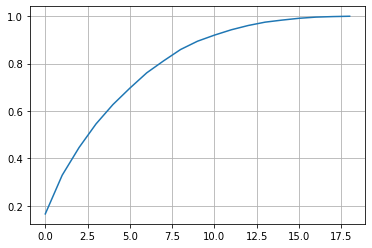

In [155]:
# Variance Captured Plots

pca1 = PCA().fit(trainX_normalized.values)
pVarExp = [sum(pca1.explained_variance_[:i])/sum(pca1.explained_variance_) for i in range(1, len(trainX.columns))]
plt.plot(pVarExp)
plt.grid()
plt.show()

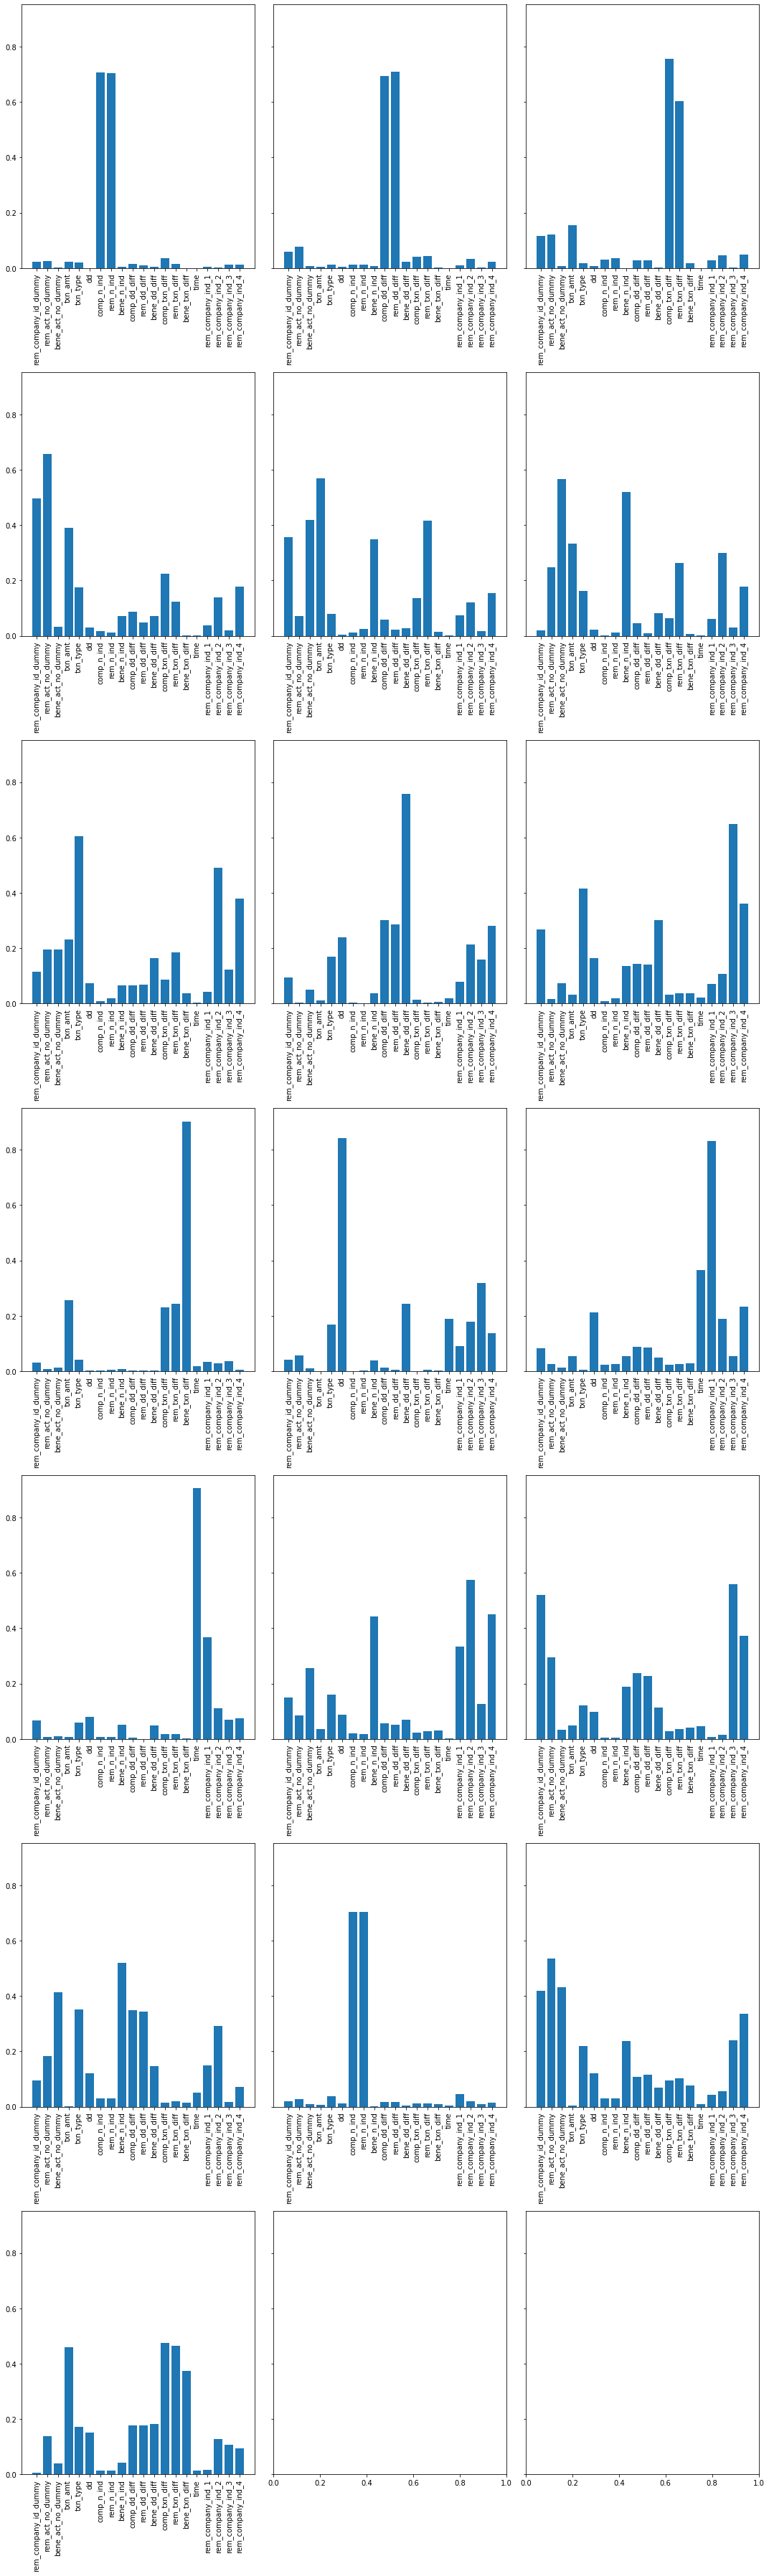

In [182]:
# Principal Components plots

fig, ax = plt.subplots(7, 3, figsize=(15, 50), sharey=True)
i = 0
j = 0
for k in range(1, 20):
    ax[i][j].bar(range(len(trainX_normalized.columns)), abs(pca1.components_[-k]))
    ax[i][j].set_xticks(range(len(trainX_normalized.columns)))
    ax[i][j].set_xticklabels(trainX_normalized.columns, rotation=90)
    j += 1
    if j==3:
        j = 0
        i += 1
plt.tight_layout()    
plt.show()

In [194]:
# pca.fit_transform(trainX_normalized)

In [166]:
# variance = pca.explained_variance_ratio_
# cum_variance = [variance[0]]
# for i in range(1,len(variance)):
#     cum_variance.append(cum_variance[i-1] + variance[i])


In [167]:
# variance

In [168]:
# cum_variance

In [169]:
# no_features = list(range(1,22))

In [170]:
# cum_variance

In [171]:
# plt.figure(figsize=[20,10])
# plt.plot(no_features,cum_variance)
# plt.show()

#  VIF

In [172]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [173]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [174]:
X_pair = train.drop('payroll_ind', axis=1)

In [175]:
VIF_values = calc_vif(X_pair)

In [176]:
VIF_values

variables          VIF
0   rem_company_id_dummy     8.879340
1       rem_act_no_dummy    13.267502
2      bene_act_no_dummy     3.255453
3                txn_amt     6.396701
4               txn_type     6.556176
5                     dd     6.686699
6             comp_n_ind  1280.264844
7              rem_n_ind  1313.404102
8             bene_n_ind     4.633158
9           comp_dd_diff    47.334593
10           rem_dd_diff    47.890991
11          bene_dd_diff     3.937980
12         comp_txn_diff    13.914291
13          rem_txn_diff    10.268582
14         bene_txn_diff     1.666470
15                  time     4.237140
16     rem_company_ind_1     1.123683
17     rem_company_ind_2     4.243943
18     rem_company_ind_3     5.095374
19     rem_company_ind_4     2.798087

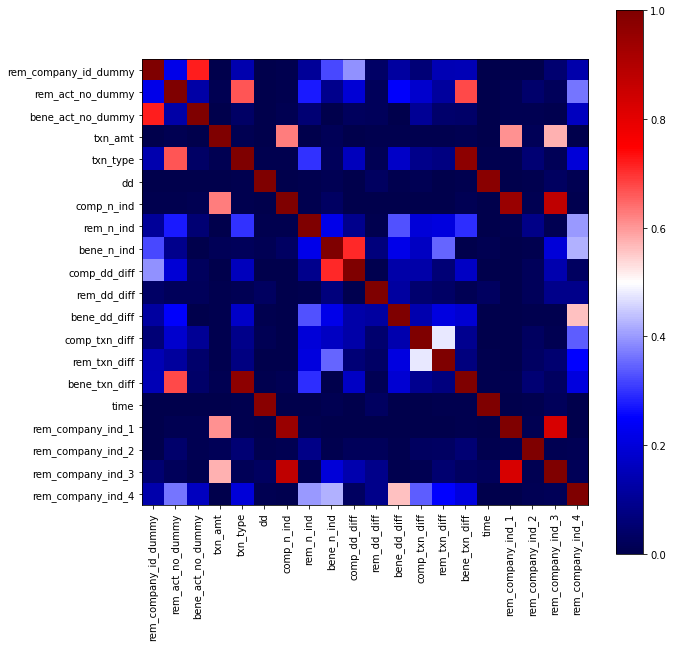

In [177]:
plt.figure(figsize=(10, 10))
fCorr = abs(X_pair.corr())
plt.imshow(fCorr.sort_index().sort_index(axis=1), cmap='seismic')
plt.colorbar()
plt.xticks(range(len(X_pair.columns)), X_pair.columns, rotation=90)
plt.yticks(range(len(X_pair.columns)), X_pair.columns)
plt.show()

In [190]:
#Removing the columns as per above PCA plot
Train_txn_final = train.drop(['rem_n_ind','rem_dd_diff','rem_txn_diff'], axis = 1)

In [191]:
Train_txn_final

rem_company_id_dummy  ...  rem_company_ind_4
txn_refr_key_dummy                        ...                   
1                              -1.262895  ...                  1
4                              -3.604513  ...                  0
5                              -4.634079  ...                  1
7                              -5.649389  ...                  0
8                              -3.604513  ...                  0
...                                  ...  ...                ...
3220108                        -3.604513  ...                  0
3220110                        -3.604513  ...                  0
3220133                        -6.042382  ...                  0
3220134                        -6.042382  ...                  0
3220135                        -6.042382  ...                  0

[1424859 rows x 18 columns]

In [192]:
# Checking VIF with new dataset
X_pair = Train_txn_final.drop('payroll_ind', axis=1)
VIF_new = calc_vif(X_pair)

In [193]:
VIF_new

variables        VIF
0   rem_company_id_dummy   8.464486
1       rem_act_no_dummy  12.236915
2      bene_act_no_dummy   3.249473
3                txn_amt   6.370756
4               txn_type   6.424507
5                     dd   6.655590
6             comp_n_ind  23.518787
7             bene_n_ind   4.628957
8           comp_dd_diff   5.170959
9           bene_dd_diff   3.800800
10         comp_txn_diff   5.270586
11         bene_txn_diff   1.662512
12                  time   4.235137
13     rem_company_ind_1   1.118192
14     rem_company_ind_2   4.188019
15     rem_company_ind_3   5.029692
16     rem_company_ind_4   2.752464